## 과적합 해결

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [60]:
# 데이터 셋 로드 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [61]:
# 데이터 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [62]:
class SimpleNN(nn.Module): 
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)   # (배치크기, h, w) -> (배치크기, 특성)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [63]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [64]:
print('배치 정규화 적용 안함')
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print('\n배치 정규화 적용')
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2537, Accuracy: 0.9233
Epoch 2 | Val Loss: 0.1806, Accuracy: 0.9468
Epoch 3 | Val Loss: 0.1629, Accuracy: 0.9529
Epoch 4 | Val Loss: 0.1481, Accuracy: 0.9553
Epoch 5 | Val Loss: 0.1258, Accuracy: 0.9620

배치 정규화 적용
Epoch 1 | Val Loss: 0.1387, Accuracy: 0.9610
Epoch 2 | Val Loss: 0.0968, Accuracy: 0.9702
Epoch 3 | Val Loss: 0.0920, Accuracy: 0.9717
Epoch 4 | Val Loss: 0.0969, Accuracy: 0.9719
Epoch 5 | Val Loss: 0.0878, Accuracy: 0.9728


In [65]:
for batch_size in [16, 32, 128]:
    print(f'batch size: { batch_size}')
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1433, Accuracy: 0.9571
Epoch 2 | Val Loss: 0.1181, Accuracy: 0.9650
Epoch 3 | Val Loss: 0.0941, Accuracy: 0.9726
Epoch 4 | Val Loss: 0.0828, Accuracy: 0.9752
Epoch 5 | Val Loss: 0.0882, Accuracy: 0.9742
batch size: 32
Epoch 1 | Val Loss: 0.1259, Accuracy: 0.9633
Epoch 2 | Val Loss: 0.0908, Accuracy: 0.9734
Epoch 3 | Val Loss: 0.0835, Accuracy: 0.9754
Epoch 4 | Val Loss: 0.0781, Accuracy: 0.9762
Epoch 5 | Val Loss: 0.0810, Accuracy: 0.9758
batch size: 128
Epoch 1 | Val Loss: 0.1497, Accuracy: 0.9575
Epoch 2 | Val Loss: 0.1189, Accuracy: 0.9643
Epoch 3 | Val Loss: 0.0993, Accuracy: 0.9699
Epoch 4 | Val Loss: 0.0921, Accuracy: 0.9732
Epoch 5 | Val Loss: 0.0851, Accuracy: 0.9738


### 드롭아웃 적용

In [66]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [67]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f'Dropout Rate: {rate}')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2590, Accuracy: 0.9215
Epoch 2 | Val Loss: 0.1847, Accuracy: 0.9439
Epoch 3 | Val Loss: 0.1723, Accuracy: 0.9496
Epoch 4 | Val Loss: 0.1525, Accuracy: 0.9557
Epoch 5 | Val Loss: 0.1402, Accuracy: 0.9595
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3479, Accuracy: 0.9012
Epoch 2 | Val Loss: 0.2831, Accuracy: 0.9197
Epoch 3 | Val Loss: 0.2695, Accuracy: 0.9233
Epoch 4 | Val Loss: 0.2472, Accuracy: 0.9298
Epoch 5 | Val Loss: 0.2309, Accuracy: 0.9317
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.4386, Accuracy: 0.6449
Epoch 2 | Val Loss: 1.2818, Accuracy: 0.6322
Epoch 3 | Val Loss: 1.2619, Accuracy: 0.6608
Epoch 4 | Val Loss: 1.1948, Accuracy: 0.6121
Epoch 5 | Val Loss: 1.1683, Accuracy: 0.6379


- 훈련 시 드롭아웃 활성화, 테스트 시 비활성화

In [68]:
def train_do(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [69]:
model = DropoutNN(dropout_rate=0.3)

# trian 모드 ==  드롭아웃 활성화
model.train()
train_do(model, train_loader, val_loader)

print()

# eval 모드 == 드롭아웃 비활성화
model.eval()
train_do(model, train_loader , val_loader)

Epoch 1 | Val Loss: 0.3807, Accuracy: 0.8877
Epoch 2 | Val Loss: 0.2964, Accuracy: 0.9117
Epoch 3 | Val Loss: 0.3073, Accuracy: 0.9094
Epoch 4 | Val Loss: 0.2580, Accuracy: 0.9243
Epoch 5 | Val Loss: 0.2416, Accuracy: 0.9295

Epoch 1 | Val Loss: 0.1213, Accuracy: 0.9649
Epoch 2 | Val Loss: 0.1127, Accuracy: 0.9657
Epoch 3 | Val Loss: 0.1269, Accuracy: 0.9617
Epoch 4 | Val Loss: 0.1251, Accuracy: 0.9654
Epoch 5 | Val Loss: 0.1272, Accuracy: 0.9635


### Learning Rate Schduler 적용

In [70]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [71]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        model.eval() 
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                
        scheduler.step()
        print(f'epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}, LearningRate: {scheduler.get_last_lr()[0]}')

In [72]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

epoch 1 | Val Loss: 0.2814, Accuracy: 0.9143, LearningRate: 0.01
epoch 2 | Val Loss: 0.2303, Accuracy: 0.9333, LearningRate: 0.01
epoch 3 | Val Loss: 0.2796, Accuracy: 0.9245, LearningRate: 0.001
epoch 4 | Val Loss: 0.1609, Accuracy: 0.9545, LearningRate: 0.001
epoch 5 | Val Loss: 0.1556, Accuracy: 0.9570, LearningRate: 0.001
epoch 6 | Val Loss: 0.1502, Accuracy: 0.9573, LearningRate: 0.0001
epoch 7 | Val Loss: 0.1473, Accuracy: 0.9587, LearningRate: 0.0001
epoch 8 | Val Loss: 0.1469, Accuracy: 0.9588, LearningRate: 0.0001
epoch 9 | Val Loss: 0.1462, Accuracy: 0.9593, LearningRate: 1e-05
epoch 10 | Val Loss: 0.1460, Accuracy: 0.9592, LearningRate: 1e-05


### 조기 종료 적용

In [81]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss =criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
            
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += ( preds == labels).sum().item()
            
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)
        
        print(f'Epoch {epoch + 1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
        
        if early_stopping and early_stopping(val_loss):
            print(f'조기종료 epoch {epoch + 1}')
            break
        
    return train_losses, val_losses

In [74]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            
        return self.counter >= self.patience    
            

In [82]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Loss: 0.2603, Accuracy: 0.9207
Epoch 2 | Loss: 0.2793, Accuracy: 0.9205
Epoch 3 | Loss: 0.2782, Accuracy: 0.9246
Epoch 4 | Loss: 0.2316, Accuracy: 0.9353
Epoch 5 | Loss: 0.2561, Accuracy: 0.9354
Epoch 6 | Loss: 0.2644, Accuracy: 0.9292
Epoch 7 | Loss: 0.2694, Accuracy: 0.9308
Epoch 8 | Loss: 0.2669, Accuracy: 0.9315
Epoch 9 | Loss: 0.2461, Accuracy: 0.9394
Epoch 10 | Loss: 0.2951, Accuracy: 0.9330
Epoch 11 | Loss: 0.2180, Accuracy: 0.9465
Epoch 12 | Loss: 0.2572, Accuracy: 0.9438
Epoch 13 | Loss: 0.2807, Accuracy: 0.9431
Epoch 14 | Loss: 0.2507, Accuracy: 0.9417
Epoch 15 | Loss: 0.2600, Accuracy: 0.9393
Epoch 16 | Loss: 0.2697, Accuracy: 0.9333
Epoch 17 | Loss: 0.2846, Accuracy: 0.9388
Epoch 18 | Loss: 0.2366, Accuracy: 0.9429
Epoch 19 | Loss: 0.2859, Accuracy: 0.9330
Epoch 20 | Loss: 0.2671, Accuracy: 0.9383
Epoch 21 | Loss: 0.3123, Accuracy: 0.9249
Epoch 22 | Loss: 0.3058, Accuracy: 0.9273
Epoch 23 | Loss: 0.2713, Accuracy: 0.9433
Epoch 24 | Loss: 0.2419, Accuracy: 0.9459
E

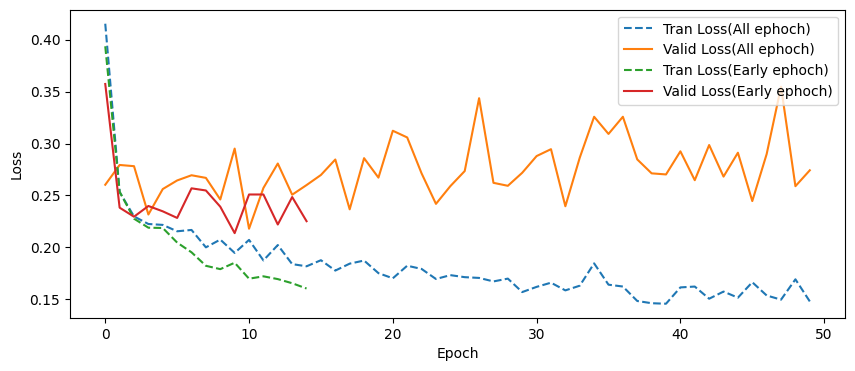

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Tran Loss(All ephoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss(All ephoch)')
plt.plot(train_es_losses, label='Tran Loss(Early ephoch)', linestyle='dashed')
plt.plot(val_es_losses, label='Valid Loss(Early ephoch)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### L1, L2 적용

In [93]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss =criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
            
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += ( preds == labels).sum().item()
            
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)
        
        print(f'epoch {epoch + 1} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
        
        weight_norm = sum(torch.norm(p).item() for p in model.parameters())
        weight_norms.append(weight_norm)
        
    return train_losses, val_losses, weight_norms

In [94]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)

epoch 1 | Train Loss: 0.4718, Val Loss: 0.2591, Accuracy: 0.9237
epoch 2 | Train Loss: 0.1950, Val Loss: 0.1665, Accuracy: 0.9514
epoch 3 | Train Loss: 0.1414, Val Loss: 0.1387, Accuracy: 0.9576
epoch 4 | Train Loss: 0.1132, Val Loss: 0.1288, Accuracy: 0.9617
epoch 5 | Train Loss: 0.0971, Val Loss: 0.1415, Accuracy: 0.9580
epoch 6 | Train Loss: 0.0841, Val Loss: 0.1437, Accuracy: 0.9578
epoch 7 | Train Loss: 0.0701, Val Loss: 0.1080, Accuracy: 0.9677
epoch 8 | Train Loss: 0.0615, Val Loss: 0.1041, Accuracy: 0.9703
epoch 9 | Train Loss: 0.0564, Val Loss: 0.1153, Accuracy: 0.9674
epoch 10 | Train Loss: 0.0492, Val Loss: 0.1027, Accuracy: 0.9722
epoch 1 | Train Loss: 0.5172, Val Loss: 0.3482, Accuracy: 0.8995
epoch 2 | Train Loss: 0.2759, Val Loss: 0.2688, Accuracy: 0.9167
epoch 3 | Train Loss: 0.2382, Val Loss: 0.2367, Accuracy: 0.9317
epoch 4 | Train Loss: 0.2194, Val Loss: 0.2397, Accuracy: 0.9286
epoch 5 | Train Loss: 0.2080, Val Loss: 0.2087, Accuracy: 0.9401
epoch 6 | Train Loss: 0.

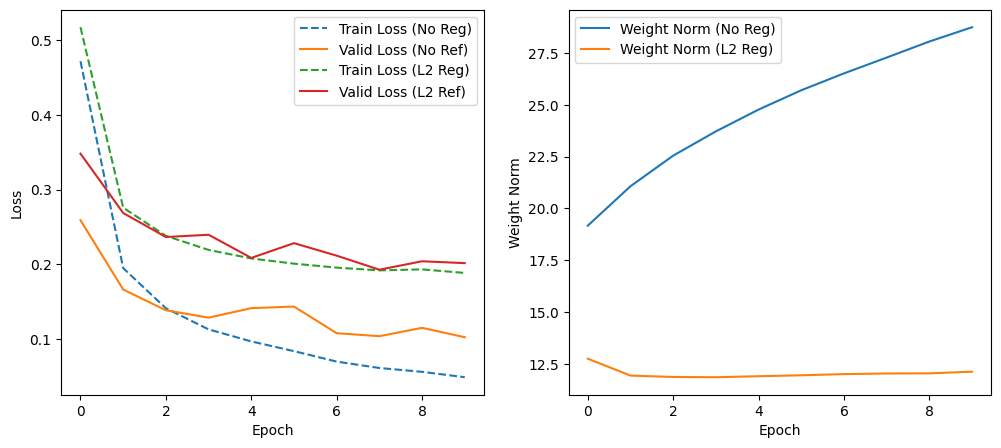

In [96]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (No Reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No Ref)')
plt.plot(train_reg_losses, label='Train Loss (L2 Reg)', linestyle='dashed')
plt.plot(val_reg_losses, label='Valid Loss (L2 Ref)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(weight_norms, label='Weight Norm (No Reg)')
plt.plot(weight_norms_reg, label='Weight Norm (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()

plt.show()